# Multiline TRL

Multiline TRL is a two-port VNA calibration utilizing at least two transmission lines with different physical lengths and at least one reflective standard that is identical on both ports. The electrical parameters of the lines don't need to be known, but the transmission lines should have identical construction (same propagation constant and characteristic impedance). The reflect standard reflection coefficient doesn't need to be known exactly, phase needs to be known with 90 degree accuracy.

If the measured phase differences of the lines is a multiple of 180 degrees the calibration is singular. The calibration accuracy is worse the closer the line measurement phases are to the singularities, the best accuracy is obtained in the two lines case when the phase difference is 90 degrees. Multiple lines can be used to extend the frequency range where the calibration is accurate.

This example demonstrates  how to use `skrf`'s NIST-style Multiline calibration (`NISTMultilineTRL`). First a [simple application](#Simple-Multiline-TRL) is presented, followed by a [full simulation](#Compare-calibrations-with-different-combinations-of-lines) to demonstrate the improvements in calibration accuracy vs the number of lines.  All  data is used in the demonstration is generated by skrf, and the code for this is given [at the end of the example](#Simulation-to-generate-the-input-data).

In addition, this example showcases the TUG multiline calibration (TUGMultilineTRL), which is an alternative to the commonly used NIST-style multiline method. The TUG method offers better statistical properties. An example comparing both calibration methods through Monte Carlo analysis is presented in the [last section](#monte-carlo-analysis---nist-vs-tug).

##  Simple Multiline TRL

### Setup

In [1]:
%matplotlib inline
import skrf
from skrf.media import CPW, Coaxial
import numpy as np
import matplotlib.pyplot as plt
skrf.stylely()

###  Load data into skrf

In [2]:
# Load all measurement data into a dictionary
data = skrf.read_all_networks('multiline_trl_data/')

# Pull out measurements by name into an ordered list
measured_names = ['thru','reflect','linep3mm','line2p3mm']
measured = [data[k] for k in measured_names]

# Switch terms
gamma_f,gamma_r = data['gamma_f'],data['gamma_r']

# DUT
dut_meas = data['DUT']

# 50 ohm termination
res_50ohm_meas = data['res_50ohm']

### Simple Multiline TRL

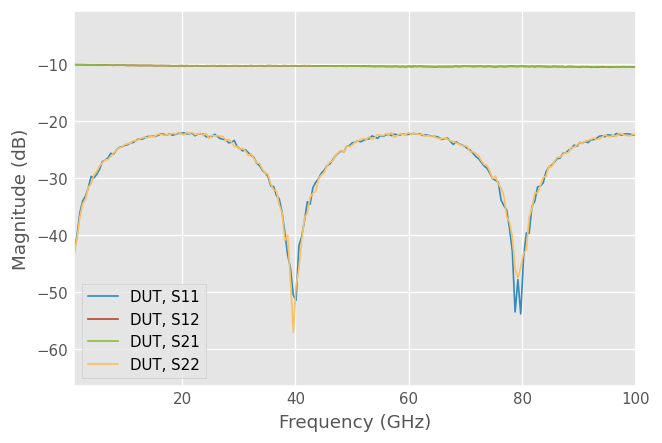

In [3]:
# define the line lengths in meters (including thru)
l = [0, 0.3e-3, 2.3e-3]

# Do the calibration
cal = skrf.NISTMultilineTRL(
    measured = measured,  # Measured standards
    Grefls = [-1], # Reflection coefficient of the reflect, -1 for short
    l = l,         # Lengths of the lines
    er_est = 7,    # Estimate of transmission line effective permittivity
    switch_terms = (gamma_f, gamma_r) # Switch terms
    )

# Correct the DUT using the above calibration
corrected = cal.apply_cal(dut_meas)

corrected.plot_s_db()

## Compare calibrations with different combinations of lines

Here we loop through different line combinations to demonstrate the difference in the calibration accuracy.

In [4]:
# Run NIST Multiline TRL calibration with different combinations of lines

# Put through and reflect to their own list ...
mtr = measured[:2]

# and lines on their own
mlines = measured[2:]

line_len = l[1:]

cals = []
duts = []

line_combinations = [[0], [1], [0,1]]

for used_lines in line_combinations:

    m = mtr + [mlines[i] for i in used_lines]

    # Add thru length to list of line lengths
    l = [l[0]] + [line_len[i] for i in used_lines]

    # Do the calibration
    cal = skrf.NISTMultilineTRL(
        measured = m,  # Measured standards
        Grefls = [-1], # Reflection coefficient of the reflect, -1 for short
        l = l,         # Lengths of the lines
        er_est = 7,    # Estimate of transmission line effective permittivity
        switch_terms = (gamma_f, gamma_r) # Switch terms
        )

    # Correct the DUT using the above calibration
    corrected = cal.apply_cal(dut_meas)
    corrected.name = 'DUT, lines {}'.format(used_lines)

    duts.append(corrected)
    cals.append(cal)

### Transmission of the corrected DUT
Plot the corrected DUT calibrated with different combination of calibration lines.

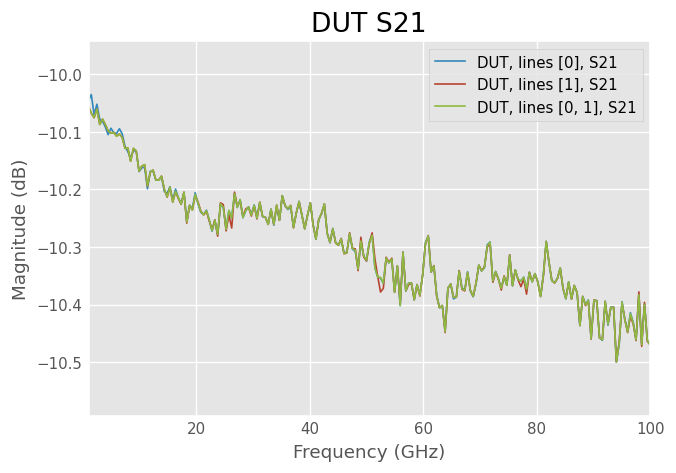

In [5]:
plt.figure()
plt.title('DUT S21')
for dut in duts:
    dut.plot_s_db(m=1, n=0)

### S11 of corrected DUT with different amount of calibration lines

S11 shows bigger changes. 

* With one short line low frequencies are very noisy
* With only the long line the calibration is very inaccurate at frequencies where the phase difference of the thru and line is close to a multiple of 180 degrees
* With both lines calibration accuracy is good everywhere

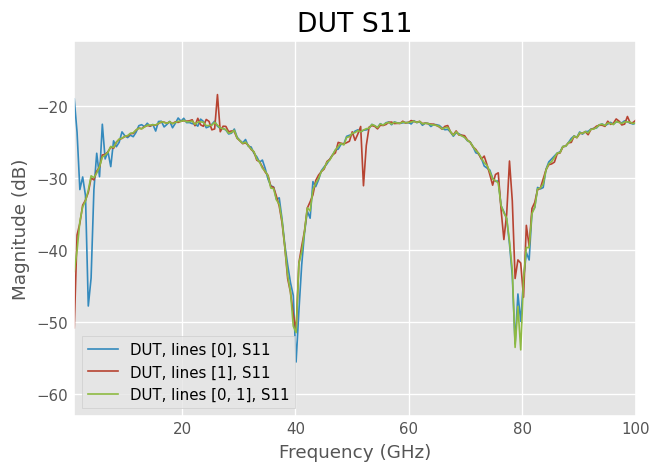

In [6]:
plt.figure()
plt.title('DUT S11')
for dut in duts:
    dut.plot_s_db(m=0, n=0)

### Normalized standard deviation of different calibrations

Normalized standard deviation can be used to measure the accuracy of the calibration. Lower number means calibration is less sensitive to the measurement noise.

 * TRL calibration with one 90 degrees long line has normalized standard deviation of 1. 
 * TRL calibration with one 180 degree long lossless line is singular and has infinite normalized standard deviation.
 * With multiple lines normalized standard deviation less than one is possible.
 
Note that the nstd is normalized such that it doesn't consider the actual measurement noise. It's calculated only from the solved propagation constant and line lengths. The threshold of how large it can be depends on the DUT being measured, measurement noise and the required accuracy of the measurement. If there are large spikes, such as are visible in the long line case below, that's a sign that the calibration is very close to singular at that frequency and the measurement accuracy is going to be poor.

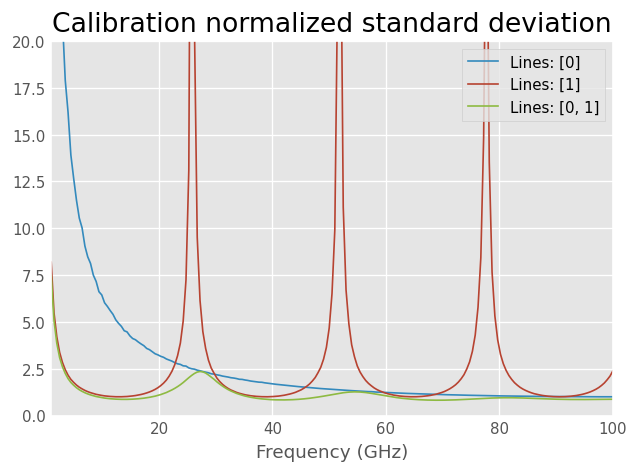

In [7]:
f_ghz = dut.frequency.f_scaled

plt.figure()
plt.title('Calibration normalized standard deviation')
for e, cal in enumerate(cals):
    plt.plot(f_ghz, cal.nstd, label='Lines: {}'.format(line_combinations[e]))
plt.ylim([0,20])
plt.legend(loc='upper right')
dut.frequency.labelXAxis()

## Calculate effective complex relative permittivity of transmission lines used in the calibration

Effective complex relative permittivity $\epsilon_{r,eff}$ of a transmission line is related to the propagation constant $\gamma$ as:

$\gamma = \frac{2\pi f}{c}\sqrt{\epsilon_{r,eff}}$, where $c$ equals the speed of light and $f$ is frequency.

In general it's a complex value with the imaginary part indicating losses.

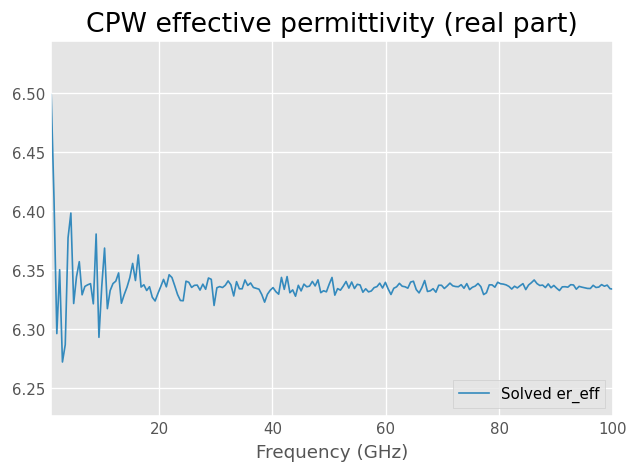

In [8]:
# Define calibration standard media 
freq = dut.frequency

# Get the cal with the both lines
cal = cals[-1]

plt.figure()
plt.title('CPW effective permittivity (real part)')
plt.plot(f_ghz, cal.er_eff.real, label='Solved er_eff')
plt.xlabel('Frequency (GHz)')
plt.legend(loc='lower right')

TRL calibration accuracy is the best when line length difference is 90 degrees. Solved propagation constant and effective permittivity however are more accurate the bigger the line length difference is. At low frequencies the estimate is noisier due to the line phase difference being small.

## Plot the phase of the solved reflection coefficient

Applying the calibration to the measured reflect standard we can get the calibrated S-parameters of the unknown reflect.

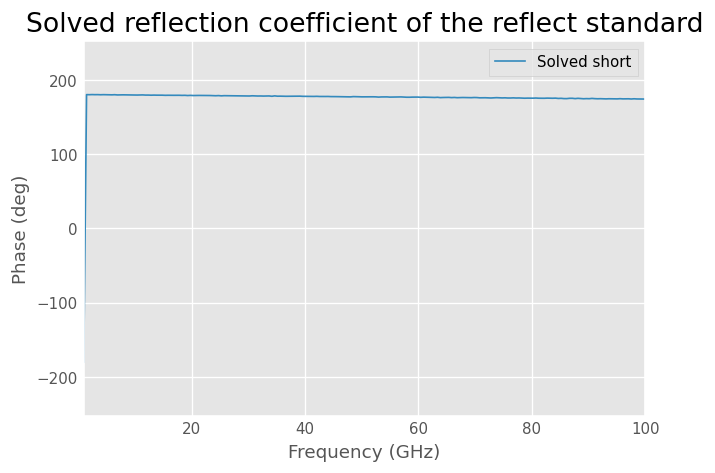

In [9]:
plt.figure()
plt.title('Solved reflection coefficient of the reflect standard')
cal.apply_cal(measured[1]).plot_s_deg(n=0, m=0, label='Solved short')

## Reference plane shift

Because propagation constant of the media is solved during the calibration it's possible to shift the reference plane by a specified distance.

The reference plane shift can be specified with `ref_plane` argument. The shift should be specified in meters, negative lengths is towards the VNA. By default the same shift is applied to both ports. Unequal shift on the two ports is supported by passing a two element list.

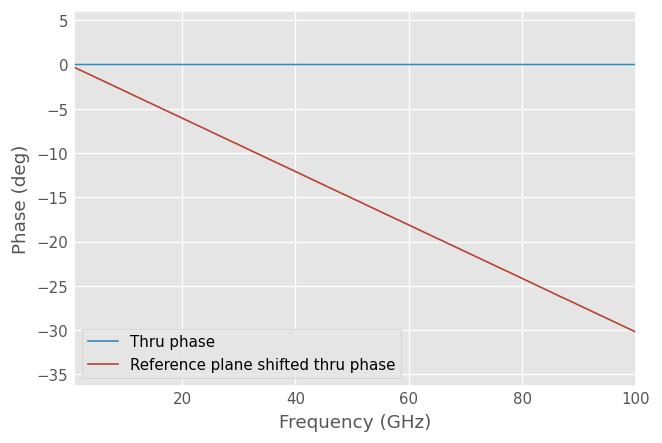

In [10]:
cal_shift = skrf.NISTMultilineTRL(
    measured = measured,  # Measured standards
    Grefls = [-1], # Reflection coefficient of the reflect, -1 for short
    l = l,         # Lengths of the lines
    er_est = 7,    # Estimate of transmission line effective permittivity
    switch_terms = (gamma_f, gamma_r), # Switch terms
    # Shift reference planes twords VNA by this amount (in m) on both ports
    ref_plane = -50e-6
    )

# Correct the DUT using the above calibration
corrected_thru = cal.apply_cal(measured[0])
corrected_thru_shifted = cal_shift.apply_cal(measured[0])

corrected_thru.plot_s_deg(m=1, n=0, label='Thru phase')
corrected_thru_shifted.plot_s_deg(m=1, n=0, label='Reference plane shifted thru phase')

## Calibration reference impedance renormalization

The reference impedance of the calibration is by default the transmission line characteristic impedance. If we know the actual characteristic impedance of the lines we can give it to the calibration routine with the `z0_line` argument to renormalize the measured S-parameters to a fixed reference `z0_ref`.

If the conductance per unit length (G) is much lower than the capacitive reactance per unit length ($j\omega C_0$), the characteristic impedance of the transmission line can be written in terms of the propagation constant $\gamma$ and capacitance per unit length $C_0$:

$Z_0 = \gamma/(j 2 \pi f C_0)$

If $C_0$ is known it can be given to the calibration routine with `c0` parameter to renormalize the calibration reference impedance to `z0_ref` (defaults to 50 ohms) assuming G = 0.
If the line is lossy the characteristic impedance is complex valued and giving a single `c0` instead of a fixed `z0_line` is usually more accurate.

In this case we know that the line characteristic impedance is actually 55 ohms. To renormalize the calibration from 55 ohms to 50 ohms we need to give `z0_line=55` argument to the calibration routine. 


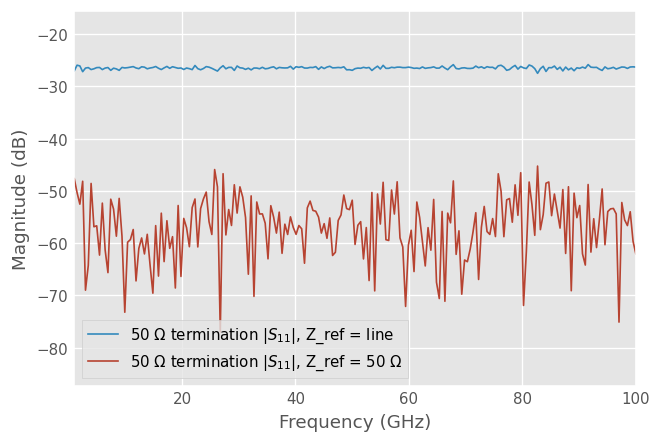

In [11]:
cal_ref = skrf.NISTMultilineTRL(
    measured = measured,  # Measured standards
    Grefls = [-1], # Reflection coefficient of the reflect, -1 for short
    l = l,         # Lengths of the lines
    er_est = 7,    # Estimate of transmission line effective permittivity
    switch_terms = (gamma_f, gamma_r), # Switch terms
    z0_line = 55, # Line actual characteristic impedance
    z0_ref = 50 # Calibration reference impedance
    )

cal.apply_cal(res_50ohm_meas).s11.plot_s_db(label='50 $\Omega$ termination |$S_{11}$|, Z_ref = line')
cal_ref.apply_cal(res_50ohm_meas).s11.plot_s_db(label='50 $\Omega$ termination |$S_{11}$|, Z_ref = 50 $\Omega$')

After renormalization the 50 ohm termination measurement shows good matching. It's not perfectly matched due to the noise in the measurements.

## Simulation to generate the input data

Here is how we made the data used above. 

### Create frequency and Media 

In [12]:
freq = skrf.F(1, 100, 201, 'GHz')

# CPW media used for DUT and the calibration standards
cpw = CPW(freq, w=40e-6, s=51e-6, ep_r=12.9,
                     t=5e-6, rho=2e-8)
print(cpw.z0[0])

# 1.0 mm coaxial media for calibration error boxes
coax1mm = Coaxial(freq, z0_port=50, Dint=0.434e-3, Dout=1.0e-3, sigma=1e8)
print(coax1mm.z0[0])

f_ghz = cpw.frequency.f*1e-9

(54.98879477905467+0j)
(50.0482480788874-0.15846377101165232j)


C:\Users\Ziad\AppData\Roaming\Python\Python311\site-packages\skrf\media\cpw.py:501: RuntimeWarning: Conductor loss calculation invalid for lineheight t (5e-06)  < 3 * skin depth (2.250790789780127e-06)
  warnings.warn(


### Make realistic looking error networks.

Propagation constant determination is iterative and doesn't work as well when the error networks are randomly generated

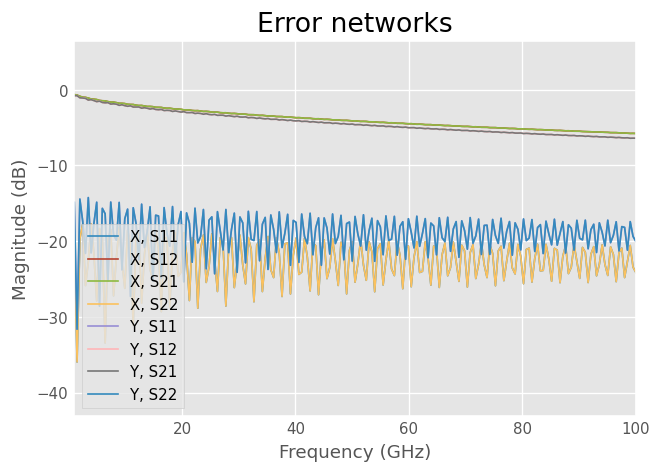

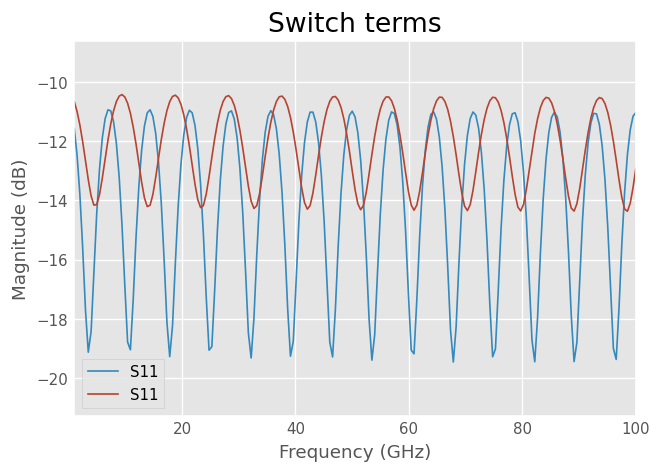

In [13]:
X = coax1mm.line(1, 'm', z0=58, name='X')
Y = coax1mm.line(1.1, 'm', z0=40, name='Y')

plt.figure()
plt.title('Error networks')
X.plot_s_db()
Y.plot_s_db()

# Realistic looking switch terms
gamma_f = coax1mm.delay_load(0.2, 21e-3, 'm', z0=60)
gamma_r = coax1mm.delay_load(0.25, 16e-3, 'm', z0=56)

plt.figure()
plt.title('Switch terms')
gamma_f.plot_s_db()
gamma_r.plot_s_db()

### Generate Fictitious measurements

In [14]:
# Lengths of the lines used in the calibration, units are in meters
line_len = [0.3e-3, 2.3e-3]
lines = [cpw.line(l, 'm') for l in line_len]

# Attenuator with mismatched feed lines
dut_feed = cpw.line(1.5e-3, 'm', z0=60)
dut = dut_feed**cpw.attenuator(-10)**dut_feed

res_50ohm = cpw.resistor(50) ** cpw.short(nports=2) ** cpw.resistor(50)

# Through and non-ideal short
# Real reflection coefficient is solved during the calibration

short = cpw.delay_short(10e-6, 'm')

actuals = [
    cpw.thru(),
    skrf.two_port_reflect(short, short),
    ]

actuals.extend(lines)

# Measured
measured = [X**k**Y for k in actuals]

# Switch termination
measured = [skrf.terminate(m, gamma_f, gamma_r) for m in measured]

# Add little noise to the measurements
for m in measured:
    m.add_noise_polar(0.001, 0.1)

names = ['thru', 'reflect', 'linep3mm', 'line2p3mm']
for k,name in enumerate(names):
    measured[k].name=name
    

# Noiseless DUT so that all the noise will be from the calibration
dut_meas = skrf.terminate(X**dut**Y, gamma_f, gamma_r)
dut_meas.name = 'DUT'

res_50ohm_meas = skrf.terminate(X**res_50ohm**Y, gamma_f, gamma_r)
res_50ohm_meas.name = 'res_50ohm'

# Put through and reflect to their own list ...
mtr = measured[:2]

# and lines on their own
mlines = measured[2:]

# write data to disk
write_data = False
if write_data:
    [k.write_touchstone(dir='multiline_trl_data/') for k in measured]
    gamma_f.write_touchstone('multiline_trl_data/gamma_f.s1p')
    gamma_r.write_touchstone('multiline_trl_data/gamma_r.s1p')
    dut_meas.write_touchstone(dir='multiline_trl_data/')
    res_50ohm_meas.write_touchstone(dir='multiline_trl_data/')

## TUG multiline TRL

TUG multiline TRL (`TUGMultilineTRL`) is a method for implementing multiline TRL calibration using a different approach than that of NIST. The definition of the calibration standards in TUG multiline is the same as in NIST multiline, requiring at least two lines and symmetric reflect. More mathematical details about TUG multiline can be found here: https://ziadhatab.github.io/posts/multiline-trl-calibration/

Below is an example comparing NIST multiline and TUG multiline. Both methods deliver the same answer. However, later in the [Monte Carlo (MC) analysis](#monte-carlo-analysis---nist-vs-tug), we will see that the TUG method delivers better statistical performance compared to the NIST method.

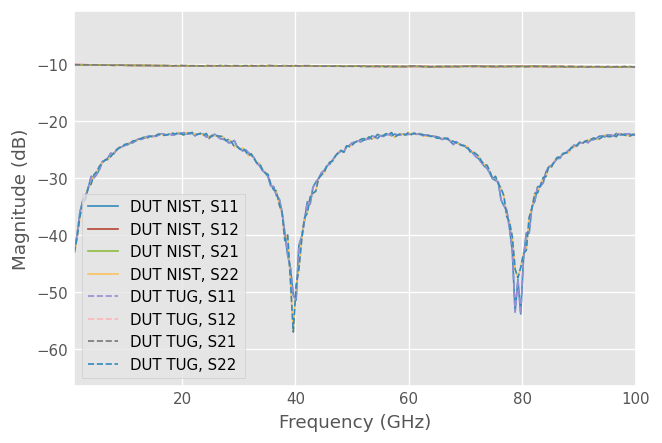

In [15]:
# Load all measurement data into a dictionary
data = skrf.read_all_networks('multiline_trl_data/')
# Pull out measurements by name into an ordered list
measured_names = ['thru','reflect','linep3mm','line2p3mm']
measured = [data[k] for k in measured_names]
# Switch terms
gamma_f,gamma_r = data['gamma_f'],data['gamma_r']
# DUT
dut_meas = data['DUT']
# define the line lengths in meters (including thru)
l = [0, 0.3e-3, 2.3e-3]

# NIST multiline TRL
cal = skrf.NISTMultilineTRL(
    measured = measured,  # Measured standards
    Grefls = [-1], # Reflection coefficient of the reflect, -1 for short
    l = l,         # Lengths of the lines
    er_est = 7,    # Estimate of transmission line effective permittivity
    switch_terms = (gamma_f, gamma_r) # Switch terms
    )

# Correct the DUT using the above calibration
corrected = cal.apply_cal(dut_meas)
corrected.name = 'DUT NIST'

corrected.plot_s_db()

# TUG multiline TRL - note the difference in 
cal = skrf.TUGMultilineTRL(
        line_meas=[measured[0]]+measured[2:], 
        line_lengths=l, 
        ereff_est=7, 
        reflect_meas=[measured[1]], 
        reflect_est=[-1], 
        switch_terms = (gamma_f, gamma_r)
        )

# Correct the DUT using the above calibration
corrected = cal.apply_cal(dut_meas)
corrected.name = 'DUT TUG'

corrected.plot_s_db(linestyle='--')

### Calibration without reflect measurement

One nice feature of `TUGMultilineTRL` is that you can use only line standards if you only care about the propagation constant and S21 and S12 of the calibrated DUT. However, to obtain correct S11 and S22 values of the calibrated DUT, you also need to provide measurement of the reflect standard. This can be seen in the example below, where S11 and S22 do not overlap when using and not using the reflect standard.

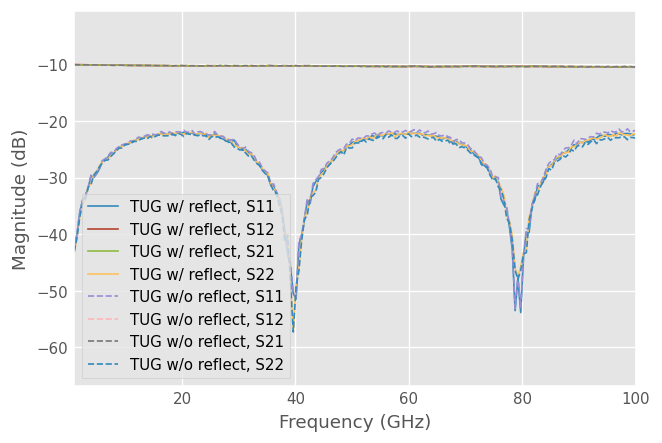

In [16]:
# Full TUG multiline TRL
cal = skrf.TUGMultilineTRL(
        line_meas=[measured[0]]+measured[2:], 
        line_lengths=l, 
        ereff_est=7, 
        reflect_meas=[measured[1]], 
        reflect_est=[-1], 
        switch_terms = (gamma_f, gamma_r)
        )

# Correct the DUT using the above calibration
corrected = cal.apply_cal(dut_meas)
corrected.name = 'TUG w/ reflect'

corrected.plot_s_db(linestyle='-')

# TUG multiline without reflect measurement
cal = skrf.TUGMultilineTRL(
        line_meas=[measured[0]]+measured[2:], 
        line_lengths=l, 
        ereff_est=7, 
        switch_terms = (gamma_f, gamma_r)
        )

# Correct the DUT using the above calibration
corrected = cal.apply_cal(dut_meas)
corrected.name = 'TUG w/o reflect'

corrected.plot_s_db(linestyle='--')

### Calibration eigenvalue

The NIST method incorporates a normalized standard deviation to emphasize the sensitivity of the calibration. Similarly, the TUG method employs a metric based on the eigenvalue of the calibration problem. The TUG multiline method solves only one weighted eigendecomposition, resulting in a real-valued eigenvalue $\lambda$. This eigenvalue signifies the stability of the calibration. The closer the eigenvalue is to zero, the more sensitive the calibration is. In essence, it can be viewed as the opposite of the normalized standard deviation defined in the NIST method.

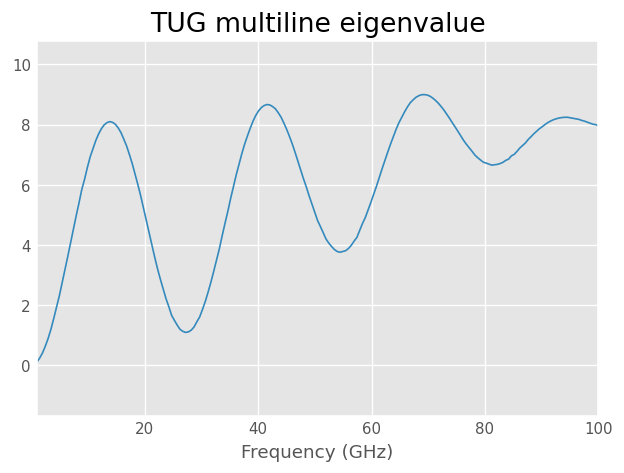

In [17]:
f_ghz = dut.frequency.f_scaled

plt.figure()
plt.title('TUG multiline eigenvalue')
plt.plot(f_ghz, cal.lambd)
dut.frequency.labelXAxis()

## Monte Carlo analysis - NIST vs TUG

Using MC analysis, we generate synthetic data of the standards with random noise and repeat the process multiple times, each time with a new noise sample. At each trial, we also compute and store the calibrated DUT, which we use to calculate the mean absolute error (MAE) of the calibration method. The general definition of MAE is as follows:

$$
\text{MAE} = \frac{1}{N}\sum_{i=1}^{N} |x_i - x_\mathrm{true}|
$$

where $x_i$ is the $i$-th MC trial and $x_\mathrm{true}$ is the true value. The code below generates the reference true value.

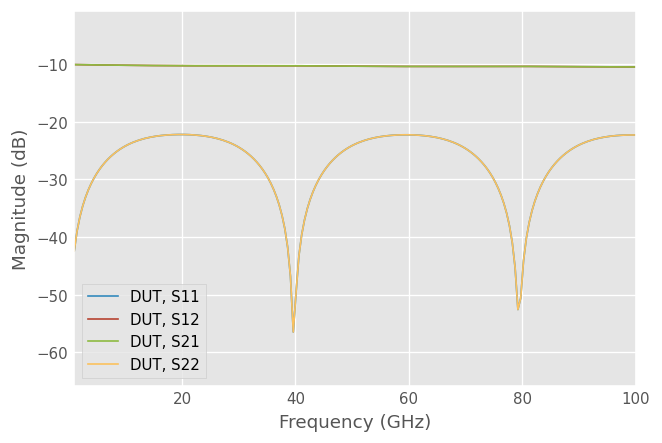

In [18]:

freq = skrf.F(1, 100, 201, 'GHz')
# CPW media used for DUT and the calibration standards
cpw = CPW(freq, w=40e-6, s=51e-6, ep_r=12.9, t=5e-6, rho=2e-8)
# 1.0 mm coaxial media for calibration error boxes
coax1mm = Coaxial(freq, z0_port=50, Dint=0.434e-3, Dout=1.0e-3, sigma=1e8)
f_ghz = cpw.frequency.f*1e-9
# Error boxes
X = coax1mm.line(1, 'm', z0=58, name='X')
Y = coax1mm.line(1.1, 'm', z0=40, name='Y')
# Realistic looking switch terms
gamma_f = coax1mm.delay_load(0.2, 21e-3, 'm', z0=60)
gamma_r = coax1mm.delay_load(0.25, 16e-3, 'm', z0=56)
# Lengths of the lines used in the calibration, units are in meters
line_lengths = [0, 0.3e-3, 2.3e-3]  # first is thru
lines = [cpw.line(l, 'm') for l in line_lengths]
# Attenuator with mismatched feed lines
dut_feed = cpw.line(1.5e-3, 'm', z0=60)
dut = dut_feed**cpw.attenuator(-10)**dut_feed
# Reflect standard
reflect_offset = 10e-6
short = cpw.delay_short(reflect_offset, 'm')
short = skrf.two_port_reflect(short, short)

# Measured... embedded in the error boxes
line_meas = [skrf.terminate(X**k**Y,gamma_f, gamma_r) for k in lines]
reflect_meas = [skrf.terminate(X**short**Y, gamma_f, gamma_r)]
dut_meas = skrf.terminate(X**dut**Y, gamma_f, gamma_r)
ereff_est = 6.3-0.0001j
reflect_est = [-1]

# NIST multiline TRL (Noiseless case as reference)
measured = [line_meas[0]] + [reflect_meas[0]] + line_meas[1:]
cal = skrf.NISTMultilineTRL(
    measured = measured,
    Grefls = reflect_est,
    l = line_lengths,
    refl_offset = reflect_offset,
    er_est = ereff_est,
    switch_terms=[gamma_f, gamma_r])

dut_ideal = cal.apply_cal(dut_meas)
dut_ideal.name = 'DUT'
dut_ideal.plot_s_db()

We now start the MC analysis by introducing noise in polar coordinates.

In [19]:
# Monte Carlo Analysis
print('MC starts: ')
M = 100 # number of trials
mag_std = 0.05 # std of magnitude (linear)
phase_std = 20 # std of phase (degrees)

cal_dut_NIST = []
cal_dut_TUG  = []

for inx in range(M):
    # add noise (make sure to copy and not override the original data)
    lines_n   = [NW.copy() for NW in line_meas]
    for NW in lines_n:
        NW.add_noise_polar(mag_std, phase_std)

    reflect_n   = [NW.copy() for NW in reflect_meas]
    for NW in reflect_n:
        NW.add_noise_polar(mag_std, phase_std)
    
    # TUG multiline TRL
    cal = skrf.TUGMultilineTRL(line_meas=lines_n, line_lengths=line_lengths, ereff_est=ereff_est, 
                reflect_meas=reflect_n, reflect_est=reflect_est, reflect_offset=reflect_offset,
                switch_terms=[gamma_f, gamma_r])
    cal_dut_TUG.append(cal.apply_cal(dut_meas))
    
    # NIST multiline TRL
    measured = [lines_n[0]] + [reflect_n[0]] + lines_n[1:]
    cal = skrf.NISTMultilineTRL(
        measured = measured,
        Grefls = reflect_est,
        l = line_lengths,
        refl_offset = reflect_offset,
        er_est = ereff_est,
        switch_terms=[gamma_f, gamma_r])
    cal_dut_NIST.append(cal.apply_cal(dut_meas))
    print(f'MC Index: {inx+1}/{M} done.', end='\r', flush=True)


MC starts: 


Finally, we compute and plot the MAE. The results show that TUG multiline has a lower error compared to the NIST method.

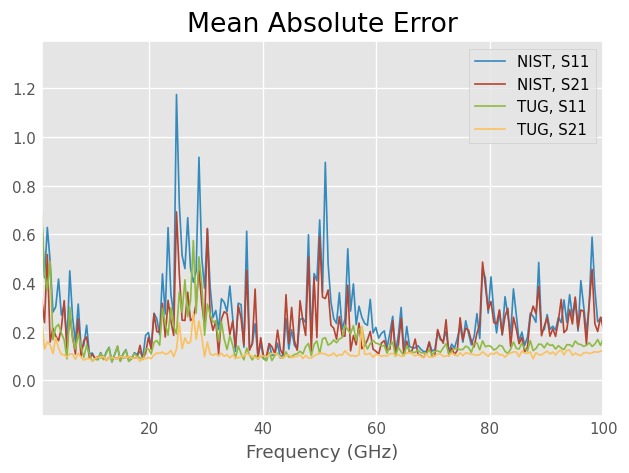

In [20]:
def dut_MAE(MC, ideal):
    # compute mean absolute error
    return np.array([ abs(x.s-ideal.s) for x in MC ]).mean(axis=0)

MAE_NIST = dut_MAE(cal_dut_NIST, dut_ideal)
MAE_TUG  = dut_MAE(cal_dut_TUG, dut_ideal)

f_ghz = dut_ideal.frequency.f_scaled

plt.figure()
plt.title('Mean Absolute Error')
plt.plot(f_ghz, MAE_NIST[:,0,0], label='NIST, S11')
plt.plot(f_ghz, MAE_NIST[:,1,0], label='NIST, S21')
plt.plot(f_ghz, MAE_TUG[:,0,0], label='TUG, S11')
plt.plot(f_ghz, MAE_TUG[:,1,0], label='TUG, S21')
plt.legend(loc='upper right')
dut_ideal.frequency.labelXAxis()